In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
from torch import nn, tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms, ToTensor
import torchvision.utils as vutils


MODEL_E_PATH = "ffhq-64x64-e.pth"
MODEL_G_PATH = "ffhq-64x64-g.pth"
MODEL_D_PATH = "ffhq-64x64-d.pth"
EXPORT_PATH = "raw-weights-ffhq-64x64"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:

class FFHQDataset(Dataset):

    def __init__(self, transform=None, target_transform=None):
        self.size = 64
        self.path = f"../data/FFHQ/{self.size}x{self.size}/"
        self.raw_bytes = {}
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        #return 10000
        return 70000

    def __getitem__(self, i):
        bd = i - i % 1000
        filepath = self.path + "{:05d}.raw".format(bd)
        if filepath not in self.raw_bytes:
            content = np.fromfile(filepath, dtype=np.uint8)
            content = content.reshape((1000, 3, self.size, self.size))
            self.raw_bytes[filepath] = content
        else:
            content = self.raw_bytes[filepath]
        return content[i%1000].astype(np.float32) / 255.0


def load_data(dataset, plot=False):
    dataloader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=True
    )
    for x in dataloader:
        print("Shape of x:", x.shape)
        break
    if plot:
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(
            next(iter(dataloader)).to(device)[:64],
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                   interpolation='nearest')
        plt.show()
    return dataloader


In [13]:
LATENT = 32
DIMS_E = [32, 64, 64, 32]
DIMS_G = [48, 64, 64, 64, 64, 48, 32]
DIMS_D = [16, 32, 64, 32]


class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        dims = DIMS_E
        self.main = nn.Sequential(
            # 3 x 64x64
            nn.Conv2d(3, dims[0], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[0]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[0] x 32x32
            nn.Conv2d(dims[0], dims[1], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[1] x 16x16
            nn.Conv2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[2] x 8x8
            nn.Conv2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[3] x 4x4
            nn.Conv2d(dims[3], LATENT, 4, 1, 0, bias=False),
            nn.Flatten()
        )

    def forward(self, x):
        return self.main(x)


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        # ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        dims = DIMS_G
        layers = [
            # LATENT
            nn.Linear(LATENT, dims[0]*4*4, bias=True),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Unflatten(1, (dims[0], 4, 4)),
            nn.Conv2d(dims[0], dims[1], 3, 1, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[1] x 4x4
            nn.ConvTranspose2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[2] x 8x8
            nn.ConvTranspose2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[3] x 16x16
            nn.ConvTranspose2d(dims[3], dims[4], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[4]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[4] x 32x32
            nn.ConvTranspose2d(dims[4], dims[5], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[5]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[5] x 64x64
            nn.Conv2d(dims[5], dims[6], 3, 1, 1, bias=False),
            nn.BatchNorm2d(dims[6]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(dims[6], 3, 3, 1, 1, bias=False),
            nn.Tanh()
        ]
        layers = [layer for layer in layers if layer is not None]
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        dims = DIMS_D
        self.main = nn.Sequential(
            # (3+3) x 64x64
            nn.Conv2d(6, dims[0], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[0]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[0] x 32x32
            nn.Conv2d(dims[0], dims[1], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[1] x 16x16
            nn.Conv2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[2] x 8x8
            nn.Conv2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[3] x 4x4
            nn.Conv2d(dims[3], 1, 4, 1, 0, bias=True),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


Shape of x: torch.Size([64, 3, 64, 64])
Encoder 149376
Encoder(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=Tru

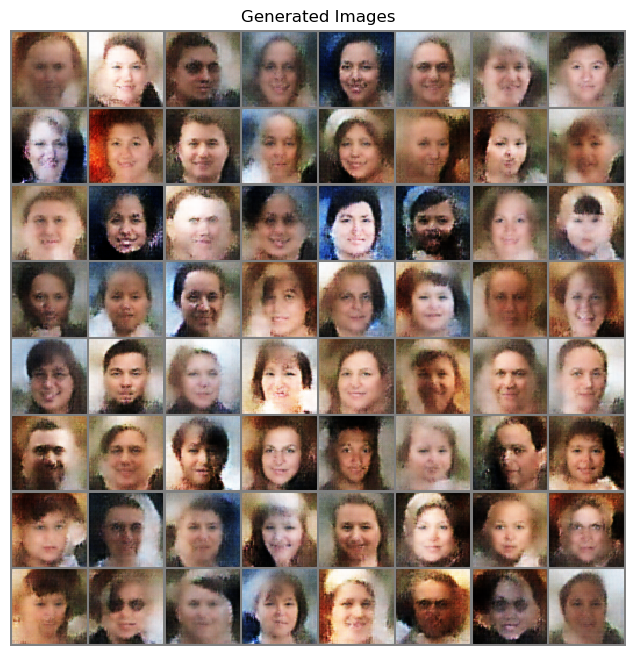

In [50]:
def weights_init(m):
    classname = m.__class__.__name__
    if 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.normal_(m.bias.data, 0.0, 0.02)
    elif 'Linear' in classname:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.1)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.1)
    else:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.02)


def train_epoch(dataloader, net_e, net_g, net_d, loss_fn, optimizer_e, optimizer_g, optimizer_d):

    net_e_params = torch.cat([x.view(-1) for x in net_e.parameters()])
    net_g_params = torch.cat([x.view(-1) for x in net_g.parameters()])
    net_d_params = torch.cat([x.view(-1) for x in net_d.parameters()])

    for batch, x in enumerate(dataloader, 0):
        real = x.to(device)*2.0-1.0

        encoded = net_e(real)
        fake = net_g(encoded)
        encoded_fake = net_e(fake)

        # loss between real and fake
        loss_diff = 4.0*torch.mean(torch.abs(fake-real))
        loss_encoded_diff = 0.5*torch.mean(torch.abs(encoded_fake-encoded))

        # KL divergence loss for VAE
        encoded_mean = torch.mean(encoded, axis=0)
        encoded_cov = torch.cov(encoded.T)
        p1 = torch.distributions.multivariate_normal.MultivariateNormal(
            encoded_mean, encoded_cov)
        p2 = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros_like(encoded_mean, device=device),
            torch.eye(LATENT, device=device))
        loss_vae = 0.01 * torch.distributions.kl_divergence(p1, p2)

        # discriminator - tell apart real and generated
        label = torch.rand((real.size(0),), device=device) < 0.5
        label = label.float()
        img1 = fake + (real-fake) * label[:, None, None, None]
        img2 = real + (fake-real) * label[:, None, None, None]
        imgs = torch.cat([img1, img2], axis=1)
        guess = net_d(imgs)
        loss_d = 0.025*loss_fn(guess.view(-1), label)
        loss_d_eg = 0.025*loss_fn(1.0-guess.view(-1), label)

        # train discriminator
        net_d.zero_grad()
        net_d_regularize = 4.0 * torch.mean(torch.abs(net_d_params))
        (loss_d+net_d_regularize).backward(retain_graph=True)
        optimizer_d.step()

        # train encoder/generator
        net_e.zero_grad()
        net_g.zero_grad()
        net_e_regularize = 0.2 * torch.mean(torch.abs(net_e_params))
        net_g_regularize = 0.2 * torch.mean(torch.abs(net_g_params))
        loss = loss_diff + loss_vae + loss_encoded_diff + loss_d_eg
        # loss = loss_diff + loss_vae + loss_d_eg
        loss = loss + net_e_regularize + net_g_regularize
        loss.backward()
        optimizer_e.step()
        optimizer_g.step()

        # output stats
        if (batch+1) % 100 == 0:
            print('[%d/%d]  loss_diff=%.4f loss_ediff=%.4f loss_vae=%.4f loss_d=%.4f loss_d_eg=%.4f loss=%.4f'
                  % (batch+1, len(dataloader),
                     loss_diff.item(), loss_encoded_diff.item(),
                     loss_vae.item(),
                     loss_d.item(), loss_d_eg.item(),
                     loss.item()))
            # break


def count_weights(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# load data
dataloader = load_data(FFHQDataset())

# creat models
net_e = Encoder().to(device)
print("Encoder", count_weights(net_e))
print(net_e)

net_g = Generator().to(device)
print("Generator", count_weights(net_g))
print(net_g)

net_d = Discriminator().to(device)
print("Discriminator", count_weights(net_d))
print(net_d)

try:
    net_e.load_state_dict(torch.load(MODEL_E_PATH, map_location=device))
    net_g.load_state_dict(torch.load(MODEL_G_PATH, map_location=device))
    net_d.load_state_dict(torch.load(MODEL_D_PATH, map_location=device))
    print("Model loaded from file.")
except BaseException as e:
    net_e.apply(weights_init)
    net_g.apply(weights_init)
    net_d.apply(weights_init)
    print("Model weights initialized.")

# loss function and optimizer
loss_fn = nn.BCELoss()
optimizer_e = torch.optim.Adam(net_e.parameters(),
                                lr=0.00005, betas=(0.5, 0.999))
optimizer_g = torch.optim.Adam(net_g.parameters(),
                                lr=0.00005, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(net_d.parameters(),
                                lr=0.00005, betas=(0.5, 0.999))

# train with progress
fixed_noise = torch.randn(64, LATENT, device=device)
for epoch in range(1, 1+1):
    # train
    print("Epoch", epoch)
    train_epoch(dataloader, net_e, net_g, net_d, loss_fn, optimizer_e, optimizer_g, optimizer_d)
    # plot
    if epoch % 1 == 0:
        generated = net_g(fixed_noise)*0.5+0.5
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(vutils.make_grid(
            generated,
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                    interpolation='nearest')
        plt.show() # on

# export weights

torch.save(net_e.state_dict(), MODEL_E_PATH)
torch.save(net_g.state_dict(), MODEL_G_PATH)
torch.save(net_d.state_dict(), MODEL_D_PATH)


Shape of x: torch.Size([64, 3, 64, 64])
Model loaded from file.


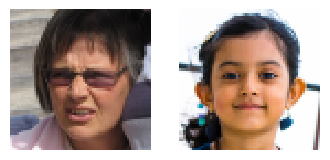

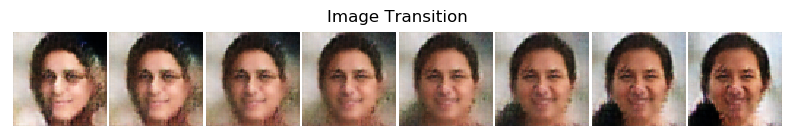

In [54]:
# load data
dataloader = load_data(FFHQDataset())

# creat models
net_e = Encoder().to(device)
net_g = Generator().to(device)

net_e.load_state_dict(torch.load(MODEL_E_PATH, map_location=device))
net_g.load_state_dict(torch.load(MODEL_G_PATH, map_location=device))
print("Model loaded from file.")

for batch in dataloader:
    img1 = batch[0:1]
    img2 = batch[1:2]
    # break

from PIL import Image
# img1 = torch.tensor([np.array(Image.open("/home/harry7557558/me.png").convert("RGB").resize((64,64)), dtype=np.float32)/255.0]).permute(0, 3, 1, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 10))
ax1.imshow(img1[0].permute(1, 2, 0))
ax2.imshow(img2[0].permute(1, 2, 0))
ax1.axis("off")
ax2.axis("off")
plt.show()

n = 8
enc1 = net_e(img1.to(device))
enc2 = net_e(img2.to(device))
t = torch.linspace(0, 1, n, device=device)
enc = enc1 + (enc2-enc1) * t[:, None]
img = net_g(enc)*0.5+0.5

plt.figure(figsize=(10, 30))
plt.axis("off")
plt.title("Image Transition")
plt.imshow(np.transpose(vutils.make_grid(
    img,
    padding=2, pad_value=1, normalize=True).cpu(), (1, 2, 0)),
            interpolation='nearest')
plt.show() # on ipynb


In [55]:
param_i = 0
layers = {}
prev_class = None
prev_path = None
for layer in net_g.main:
    if layer.__class__.__name__ == "Linear":
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
        if len(list(layer.parameters())) > 1:
            data = list(layer.parameters())[1].data.cpu()
            shape = '_'.join(map(str, data.shape))
            path = EXPORT_PATH+"/b{:02d}_{}.bin".format(param_i, shape)
            layers[path] = data.numpy()
            prev_path = (prev_path, path)
    elif layer.__class__.__name__ in ['Conv2d', "ConvTranspose2d"]:
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()  # no bias
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
    elif layer.__class__.__name__ == "BatchNorm2d":
        assert len(layers[prev_path].shape) == 4
        mu = layer.running_mean.cpu()
        var = layer.running_var.cpu()
        invstdev = 1.0 / (var + 1e-5)**0.5
        data = list(layer.parameters())
        gamma, beta = data[0].data.cpu(), data[1].data.cpu()
        a = gamma * invstdev
        b = beta - mu * gamma * invstdev
        a, b = a.numpy(), b.numpy()
        # print(prev_class, layers[prev_path].shape, a.shape)
        if prev_class == 'ConvTranspose2d':
            layers[prev_path] = layers[prev_path] * a[:, np.newaxis, np.newaxis]
        elif prev_class == 'Conv2d':
            layers[prev_path] = layers[prev_path] * a[:, np.newaxis, np.newaxis, np.newaxis]
        # print(a.shape, b.shape, layers[prev_path].shape)
        shape = '_'.join(map(str, b.shape))
        path = EXPORT_PATH+"/b{:02d}_{}.bin".format(param_i, shape)
        layers[path] = b
    else:
        print(layer.__class__.__name__)
        prev_path = None
    prev_class = layer.__class__.__name__

for path, data in layers.items():
    data.astype(np.float32).tofile(path)

LeakyReLU
Unflatten
LeakyReLU
LeakyReLU
LeakyReLU
LeakyReLU
LeakyReLU
LeakyReLU
Tanh
